<div style="text-align: center; padding: 20px; background-color: #A020F0; border-radius: 10px; margin: 20px 0;">
    <h1 style="color: #00FF00 	;">Web Scraping and Introductory Data Analysis</h1>
    <hr style="border: 2px solid #000000;">
    <h2 style="color: #555;">Group Members:</h2>
    <ul style="list-style-type: none; padding: 0; color: #000000">
        <li style="margin-bottom: 5px;">Ava Mirmohammadmahdi</li>
        <li style="margin-bottom: 5px;">Sadegh Abofazeli</li>
        <li style="margin-bottom: 5px;">Amir Ali Vahidi</li>
    </ul>
</div>


In this project, our overarching objectives can be categorized into two main phases:
1. **Web Scraping**
    - Data Collection:\
     Utilize web scraping methods to gather transaction data from the [Etherscan.io](https://etherscan.io) webpage.

    - Data Cleaning:\
     Enhance the quality of the collected data by implementing cleaning procedures. This may involve tasks such as removing duplicate transactions, filtering out zero-value transactions, and other relevant optimizations.

2. **Data Analysis**
    - Data Visualization:\
     Employ various plotting functions to visually represent and analyze the obtained data. Visualization aids will provide insights and facilitate a better understanding of the dataset.

    - Comparative Analysis:\
     Compare and analyze the results derived from the visualizations, identifying patterns, trends, or anomalies within the Ethereum transaction data.

## Part 1: Web Scraping 

### Environment Setup
To initiate our data exploration, let's begin by importing essential libraries. Selenium and beatifulsoup libraries are used for collecting data from website. Other libraries are used for tasks such as sampling, plotting, and in-depth data analysis.

In [9]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import time


In [10]:
WEB_URL = "https://etherscan.io/txs"
TRX_TABLE_XPATH_HEAD = "//table[@class='table table-hover table-align-middle mb-0']/thead/tr/th"
TRX_TABLE_XPATH_BODY = "//table[@class='table table-hover table-align-middle mb-0']/tbody/tr"
ETHER_SCAN_CSV_FILE = "etherscan.csv"
NUM_OF_BLOCKS = 10


We begin by initializing a WebDriver using Selenium. Specifically, we use the Firefox WebDriver to instantiate a Firefox browser instance. This WebDriver will facilitate interactions with web elements. The WebDriver navigates to the [Etherscan.io](https://etherscan.io/txs).  
An assertion is used to verify that the title of the webpage contains the keyword "Ethereum". This step ensures that the WebDriver successfully loaded the expected webpage.  
It is good to mention that, as stated in the Selenium documentation, the webdriver will wait for a page to load by default via the `.get()` method before attempting to scrape the data.

In [11]:
driver = webdriver.Firefox()
def setupWebDriver():
    driver.get(WEB_URL)
    assert "Ethereum" in driver.title

setupWebDriver()

The getTrxTableHeaders function extracts transactions table headers from HTML source code using the table's id. It modifies the extracted headers to match a specific format and returns the modified header as a list.  
The getTrxTableBody function extracts the body of a transaction table from HTML source code using Beautiful Soup. It iterates through each row of the table, extracts the text from each cell, removes newline characters. Additionally, it captures the block number from the first row of the table. 

In [12]:
def getTrxTableHeaders(html_src):
    trx_table_head = html_src.find(id = "ContentPlaceHolder1_theadAllTransactionTable").find_all('th')
    header = [header.get_text().replace("\n", "") for header in trx_table_head]
    header[2] = "Method"
    header.pop(0)
    header.pop(5)
    header.insert(3, "Date")
    header.insert(5, "Local Time")
    header.append("Gas Price")
    return header

def getTrxTableBody(rows_elements, html_src):
    trx_table_body = html_src.find('table')
    trx_table_body = trx_table_body.find_all('tr')
    block_number = 0
    for i in range(1, len(trx_table_body)):
        rows = trx_table_body[i].find_all('td')
        element = [elem.get_text() for elem in rows]
        element = list(map(lambda x: x.replace("\n", ""), element))
        element.pop(8)
        element.pop(0)
        if i == 1:
            block_number = int(element[2])
        rows_elements.append(element)
    return rows_elements, block_number

In this part we iterate through the transaction table, continuously fetching data until a certain condition is met. We click on the "Next" button in order to implement pagination handling to navigate through the pages and collect the last 10 blocks' transactions data. In this case that certain condition is the block number; At each iteration we get the first row's block number and compare it to the latest block number that we have.  
In the end we save the data into a DataFrame.

In [13]:
def saveTransactionsToDp(header, body):
    transactionsDf = pd.DataFrame(body, columns=header)
    transactionsDf.to_csv(ETHER_SCAN_CSV_FILE, mode='a', header=False, index=False)
    return transactionsDf
    
def scrapeWebPage():
    html_src = BeautifulSoup(driver.page_source, 'html.parser')
    header = getTrxTableHeaders(html_src)
    rows_elements = []
    body, latest_block_number = getTrxTableBody(rows_elements, html_src)
    while True:
        html_src = BeautifulSoup(driver.page_source, 'html.parser')
        body, block_number = getTrxTableBody(body, html_src)
        next_button = driver.find_element(By.XPATH, '//a[@aria-label="Next"]')
        time.sleep(0.2)
        next_button.click()
        if block_number == latest_block_number - NUM_OF_BLOCKS:
            break
    transactionsDf = saveTransactionsToDp(header, body)
    driver.close()
    return latest_block_number, transactionsDf


In [14]:
latest_block_number, transactionsDf = scrapeWebPage()
def saveToCsvFile(transactionsDf):
    transactionsDf.to_csv(ETHER_SCAN_CSV_FILE, index=False)
    
saveToCsvFile(transactionsDf)

## Part 2: Data Analysis

#### Clean Transactions Data
We duplicate the DataFrame into a new object to avoid the necessity of recollecting data, ensuring that any modifications made to the original DataFrame do not affect the stored information.

In [15]:
transactionsDf_raw = transactionsDf.copy()

In [16]:
display(transactionsDf)

,Txn Hash,Method,Block,Date,Age,Local Time,From,To,Value,Txn Fee,Gas Price
0,0x46d8f310d4dc9d8adfade1901538db7d6e8252b19633...,Transfer,19399902,2024-03-09 20:23:11,14 secs ago,1710015791,titanbuilder.eth,Lido: Execution Layer Rewards Vault,0.092025983 ETH,0.0013792,62.37630852
1,0x13a652a17060859a7f9ba807dd9bd0973f94f0a5a63b...,Sell To Uniswap,19399902,2024-03-09 20:23:11,14 secs ago,1710015791,0x0fcDD94c...CEdc03930,0x: Exchange Proxy,0 ETH,0.00710146,62.37730852
2,0x248c1b05c4e64921d19d0228732e0327a6b11e7dcefe...,Transfer,19399902,2024-03-09 20:23:11,14 secs ago,1710015791,Binance 16,Arkham: ARKM Token,0 ETH,0.00382292,64.37630852
3,0x168dcebb2e5901d96bdf8351462a61f97d4fc0c891c1...,Transfer,19399902,2024-03-09 20:23:11,14 secs ago,1710015791,Binance 16,0xC138D0A3...265700eE6,3.07882565 ETH,0.0013519,64.37630852
4,0x3a9df82cd6692b6797565f017021a9e478af74d887a5...,Transfer,19399902,2024-03-09 20:23:11,14 secs ago,1710015791,Binance 15,0x9C6D9d17...F357c19ad,0.02874061 ETH,0.0013519,64.37630852
...,...,...,...,...,...,...,...,...,...,...,...
2595,0x938345426eeda65270d8b0a2959990e95126a992e1d5...,Execute,19399892,2024-03-09 20:21:11,3 mins ago,1710015671,0x9e6b410D...E57A53a2B,Uniswap: Universal Router,0 ETH,0.01143806,60.93767683
2596,0x969ba56195240960fcd843fa8f7ec8db29f55a971ae8...,Execute,19399892,2024-03-09 20:21:11,3 mins ago,1710015671,0x42F631F5...79D81e41B,Uniswap: Universal Router,0 ETH,0.01268771,60.93767683
2597,0x7c93ab051af0a95aafd958808c6cba08801a8a22783a...,Swap,19399892,2024-03-09 20:21:11,3 mins ago,1710015671,0xC5c7a2B0...a3610b59B,Metamask: Swap Router,0 ETH,0.01255896,60.93772533
2598,0x6078bf4043ee1a0a102ad91c6f187d5b1c29f2fe8df7...,Execute,19399892,2024-03-09 20:21:11,3 mins ago,1710015671,0x4041Da01...974238399,Uniswap: Universal Router,0 ETH,0.0136429,60.93767683


In [17]:
transactionsDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Txn Hash    2600 non-null   object
 1   Method      2600 non-null   object
 2   Block       2600 non-null   object
 3   Date        2600 non-null   object
 4   Age         2600 non-null   object
 5   Local Time  2600 non-null   object
 6   From        2600 non-null   object
 7   To          2600 non-null   object
 8   Value       2600 non-null   object
 9   Txn Fee     2600 non-null   object
 10  Gas Price   2600 non-null   object
dtypes: object(11)
memory usage: 223.6+ KB


Due to the dynamic nature of the Etherscan.io webpage, pressing the "next" button during transaction collection may introduce duplicate entries into the DataFrame. To ensure data accuracy and eliminate redundancy, we systematically identify and remove these duplicate transactions from the dataset.

In [18]:
print(f"Rows count before removing duplicate rows: {transactionsDf.shape[0]}")
transactionsDf.drop_duplicates(subset=['Txn Hash'], inplace=True)
print(f"Rows count after removing duplicate rows: {transactionsDf.shape[0]}")

transactionsDf_removed_dups = transactionsDf.copy()

Rows count before removing duplicate rows: 2600
Rows count after removing duplicate rows: 1800


This code snippet optimizes the transactionsDf DataFrame by:

* Column Pruning:

Discarding extraneous columns ('Date', 'Age', 'From', 'To', 'Local Time', 'Gas Price') for a more focused dataset.
* Zero-Value Transaction Exclusion:

Filtering out transactions with zero values to refine the dataset and concentrate on meaningful transactions.
* Numeric Conversion:

Converting the 'Value' column to a numeric data type for further analysis

In [19]:
transactionsDf.drop(columns=['Date', 'Age', 'From', 'To', 'Local Time', 'Gas Price'], inplace=True)

transactionsDf['Block'] = transactionsDf['Block'].astype(int)
transactionsDf['Txn Fee'] = transactionsDf['Txn Fee'].str.replace('"', '').str.replace(',', '').astype(str)
transactionsDf['Txn Fee'] = transactionsDf['Txn Fee'].astype(float)
transactionsDf['Value'] = transactionsDf['Value'].str.replace('"', '').str.replace(',', '').astype(str)
transactionsDf['Value'] = transactionsDf['Value'].apply(lambda x: float(x.split(' ')[0]) if 'ETH' in x else float(x.split(' ')[0])/10**18)

transactionsDf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1800 entries, 0 to 2599
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Txn Hash  1800 non-null   object 
 1   Method    1800 non-null   object 
 2   Block     1800 non-null   int32  
 3   Value     1800 non-null   float64
 4   Txn Fee   1800 non-null   float64
dtypes: float64(2), int32(1), object(2)
memory usage: 77.3+ KB


Eliminate rows containing invalid block numbers that were inadvertently collected during the full-page web scraping process.

In [20]:
print("Before removing Extra Blocks:")
print(f"Max Block number: {transactionsDf['Block'].max()}, Min Block number:  {transactionsDf['Block'].min()}")
print(f"Unique Values in Block Column: {transactionsDf['Block'].nunique()}")

block_mask = (transactionsDf['Block'] > latest_block_number - NUM_OF_BLOCKS) & (transactionsDf['Block'] <= latest_block_number)
transactionsDf = transactionsDf[block_mask]

print("\nAfter removing Extra Blocks:")
print(f"Max Block number: {transactionsDf['Block'].max()}, Min Block number:  {transactionsDf['Block'].min()}")
print(f"Unique Values in Block Column: {transactionsDf['Block'].nunique()}")

Before removing Extra Blocks:
Max Block number: 19399903, Min Block number:  19399892
Unique Values in Block Column: 12

After removing Extra Blocks:
Max Block number: 19399902, Min Block number:  19399893
Unique Values in Block Column: 10


In [21]:
transactionsDf_cleansed = transactionsDf.copy()

For the purpose of a more comprehensive analysis, we will conduct assessments on two different datasets: one comprising the original data, including zero-value transactions, and the other excluding transactions with zero values.

In [22]:
transactionsDf_with_zero_txn = transactionsDf.copy()
display(transactionsDf_with_zero_txn.describe())

transactionsDf_without_zero_txn = transactionsDf[transactionsDf['Value'] > 0]
display(transactionsDf_without_zero_txn.describe())

,Block,Value,Txn Fee
count,1.668000e+03,1668.000000,1668.000000
mean,1.939990e+07,0.576101,0.005793
std,2.882579e+00,10.496836,0.008577
min,1.939989e+07,0.000000,0.001310
25%,1.939990e+07,0.000000,0.001483
50%,1.939990e+07,0.000000,0.003091
75%,1.939990e+07,0.057130,0.008233
max,1.939990e+07,400.004643,0.160783


,Block,Value,Txn Fee
count,8.200000e+02,8.200000e+02,820.000000
mean,1.939990e+07,1.171874e+00,0.004658
std,2.943112e+00,1.495224e+01,0.008174
min,1.939989e+07,7.700000e-17,0.001310
25%,1.939989e+07,1.404988e-02,0.001386
50%,1.939990e+07,6.146790e-02,0.001482
75%,1.939990e+07,2.231549e-01,0.007994
max,1.939990e+07,4.000046e+02,0.160783


## Part 2: Data Analysis

### **Transaction Fee Distribution Analysis**

We analyze the distribution of transaction fees in two datasets: one including zero-value transactions and the other excluding them.

#### Libraries Used:
- `matplotlib`: For creating histograms and visualizations.

#### Calculation of Bin Width and Size
The bin width and size are calculated using the Freedman-Diaconis rule, which is based on the interquartile range (IQR) and the number of transactions (n). The rule is defined as follows:

\[
\begin{align*}
\text{Bin Width with Zero Transactions} &= 2 \cdot \text{IQR} \cdot n^{-1/3} \\
\text{Bin Width without Zero Transactions} &= 2 \cdot \text{IQR} \cdot n^{-1/3} \\
\text{Bin Size with Zero Transactions} &= \text{round}\left(\frac{\text{max}(\text{Transaction Fee}) - \text{min}(\text{Transaction Fee})}{\text{Bin Width with Zero Transactions}}\right) \\
\text{Bin Size without Zero Transactions} &= \text{round}\left(\frac{\text{max}(\text{Transaction Fee}) - \text{min}(\text{Transaction Fee})}{\text{Bin Width without Zero Transactions}}\right)
\end{align*}
\]

As a result, the bin width and size are calculated for both datasets, allowing for the creation of histograms with appropriate binning.

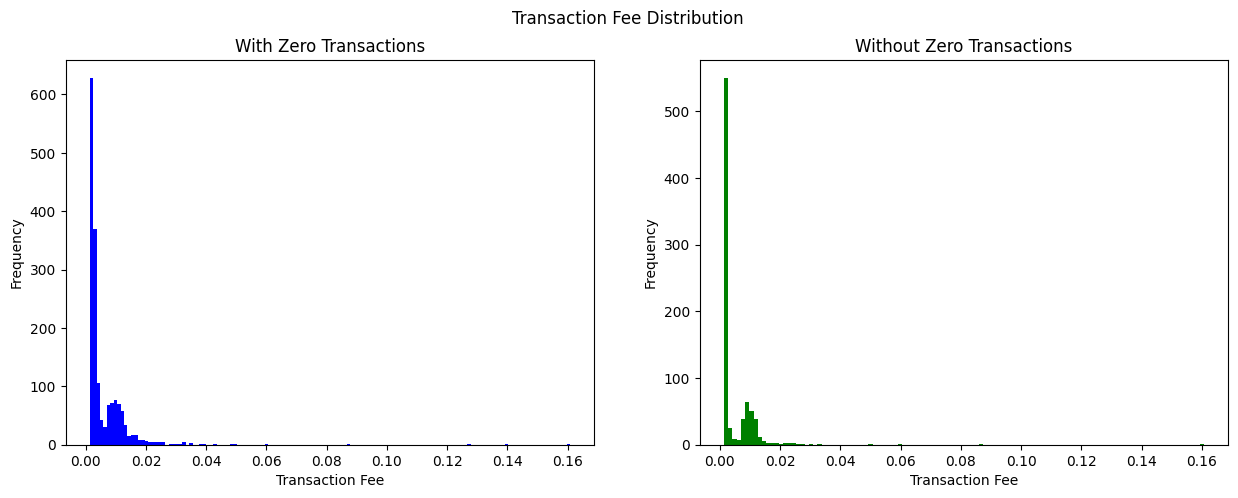

In [23]:
bin_width_with_zero_txn = 2 * (transactionsDf_with_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_with_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_with_zero_txn['Txn Fee'].count() ** (-1/3)
bin_width_without_zero_txn = 2 * (transactionsDf_without_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_without_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_without_zero_txn['Txn Fee'].count() ** (-1/3)
bin_size_with_zero_txn = round((transactionsDf_with_zero_txn['Txn Fee'].max() - transactionsDf_with_zero_txn['Txn Fee'].min()) / bin_width_with_zero_txn)
bin_size_without_zero_txn = round((transactionsDf_without_zero_txn['Txn Fee'].max() - transactionsDf_without_zero_txn['Txn Fee'].min()) / bin_width_without_zero_txn)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution')

ax[0].hist(transactionsDf_with_zero_txn['Txn Fee'], bins=bin_size_with_zero_txn, color='blue')
ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Fee')
ax[0].set_ylabel('Frequency')

ax[1].hist(transactionsDf_without_zero_txn['Txn Fee'], bins=bin_size_without_zero_txn, color='green')
ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Fee')
ax[1].set_ylabel('Frequency')

plt.show()


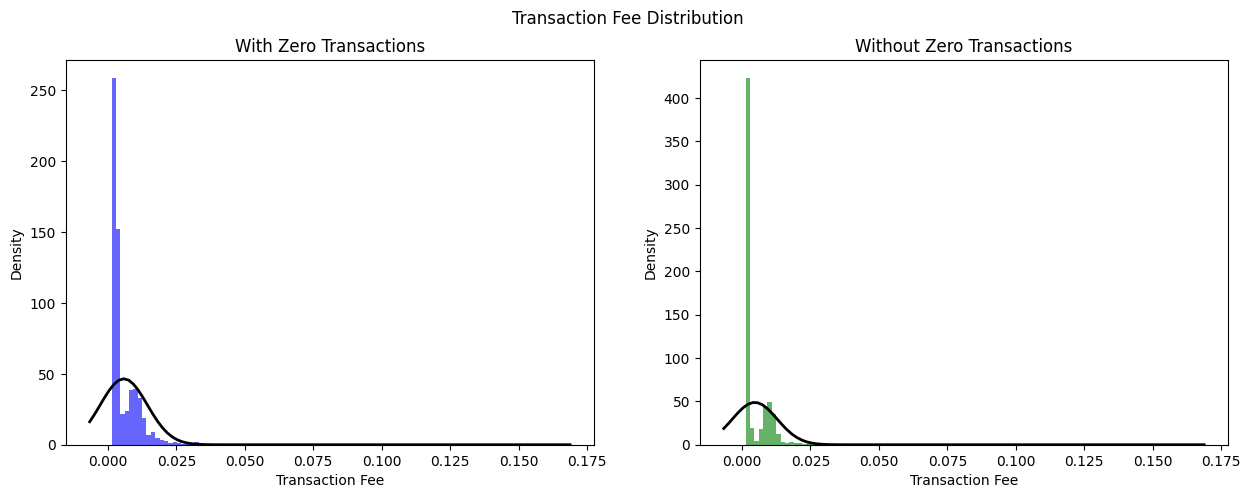

In [24]:
bin_width_with_zero_txn = 2 * (transactionsDf_with_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_with_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_with_zero_txn['Txn Fee'].count() ** (-1/3)
bin_width_without_zero_txn = 2 * (transactionsDf_without_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_without_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_without_zero_txn['Txn Fee'].count() ** (-1/3)
bin_size_with_zero_txn = round((transactionsDf_with_zero_txn['Txn Fee'].max() - transactionsDf_with_zero_txn['Txn Fee'].min()) / bin_width_with_zero_txn)
bin_size_without_zero_txn = round((transactionsDf_without_zero_txn['Txn Fee'].max() - transactionsDf_without_zero_txn['Txn Fee'].min()) / bin_width_without_zero_txn)

if bin_size_with_zero_txn > 50:
    bin_size_with_zero_txn = 100
if bin_size_without_zero_txn > 50:
    bin_size_without_zero_txn = 100

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution')

ax[0].hist(transactionsDf_with_zero_txn['Txn Fee'], bins=bin_size_with_zero_txn, color='blue', density=True, alpha=0.6)
ax[1].hist(transactionsDf_without_zero_txn['Txn Fee'], bins=bin_size_without_zero_txn, color='green', density=True, alpha=0.6)

mu1, std1 = norm.fit(transactionsDf_with_zero_txn['Txn Fee'])
mu2, std2 = norm.fit(transactionsDf_without_zero_txn['Txn Fee'])

xmin1, xmax1 = ax[0].get_xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, std1)
ax[0].plot(x1, p1, 'k', linewidth=2)

xmin2, xmax2 = ax[1].get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
ax[1].plot(x2, p2, 'k', linewidth=2)

ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Fee')
ax[0].set_ylabel('Density')

ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Fee')
ax[1].set_ylabel('Density')

plt.show()

#### Plotting the Histogram of transaction fee using log transformation

In [25]:
def calcBinSize(df):
    bin_width = 2 * (df.quantile(0.75) - df.quantile(0.25)) * df.count() ** (-1/3)
    bin_size = round((df.max() - df.min()) / bin_width)
    if bin_size > 50:
        bin_size = 100
    return bin_size

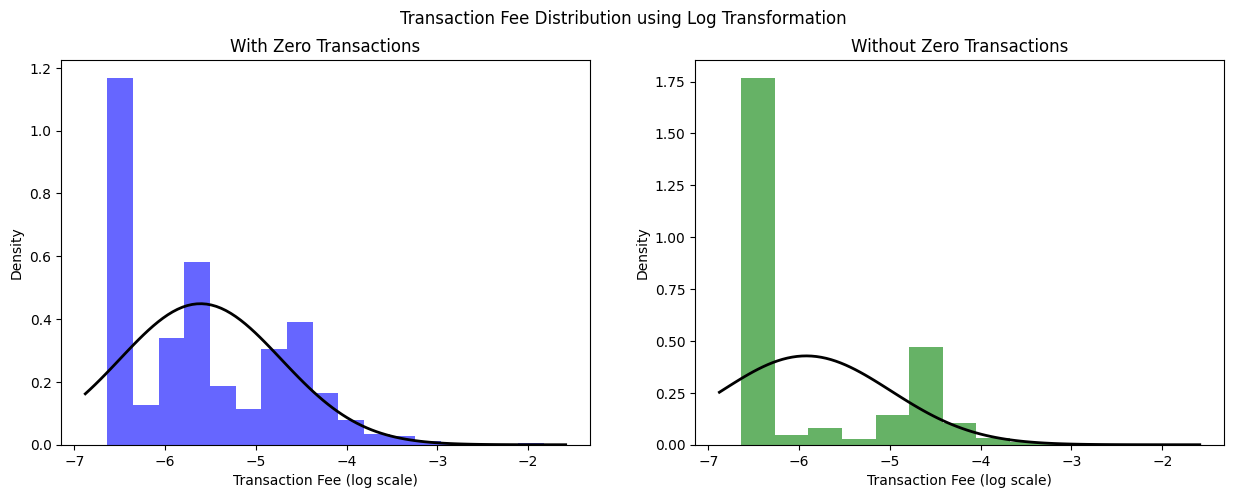

In [26]:
bin_size_with_zero_txn = calcBinSize(np.log(transactionsDf_with_zero_txn['Txn Fee']))
bin_size_without_zero_txn = calcBinSize(np.log(transactionsDf_without_zero_txn['Txn Fee']))
    
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution using Log Transformation')

ax[0].hist(np.log(transactionsDf_with_zero_txn['Txn Fee']), bins=bin_size_with_zero_txn, color='blue', density=True, alpha=0.6)
ax[1].hist(np.log(transactionsDf_without_zero_txn['Txn Fee']), bins=bin_size_without_zero_txn, color='green', density=True, alpha=0.6)

mu1, std1 = norm.fit(np.log(transactionsDf_with_zero_txn['Txn Fee']))
mu2, std2 = norm.fit(np.log(transactionsDf_without_zero_txn['Txn Fee']))

xmin1, xmax1 = ax[0].get_xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, std1)
ax[0].plot(x1, p1, 'k', linewidth=2)

xmin2, xmax2 = ax[1].get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
ax[1].plot(x2, p2, 'k', linewidth=2)

ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Fee (log scale)')
ax[0].set_ylabel('Density')

ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Fee (log scale)')
ax[1].set_ylabel('Density')

plt.show()

Transaction Value Distribution

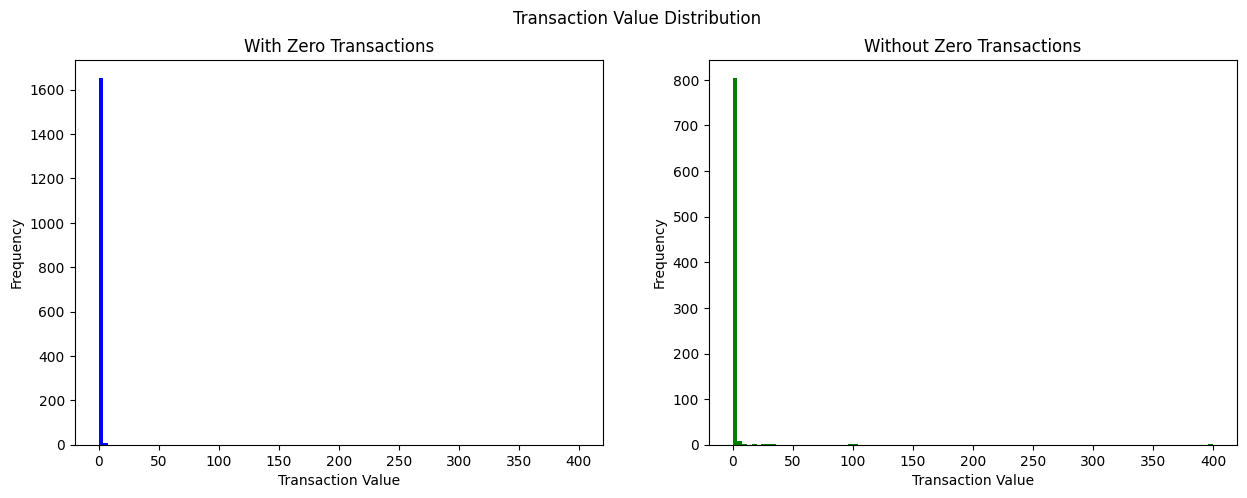

In [27]:

bin_size_with_zero_txn = calcBinSize(transactionsDf_with_zero_txn['Value'])
bin_size_without_zero_txn = calcBinSize(transactionsDf_without_zero_txn['Value'])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution')

ax[0].hist(transactionsDf_with_zero_txn['Value'], bins=bin_size_with_zero_txn, color='blue')
ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Value')
ax[0].set_ylabel('Frequency')

ax[1].hist(transactionsDf_without_zero_txn['Value'], bins=bin_size_without_zero_txn, color='green')
ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Value')
ax[1].set_ylabel('Frequency')

plt.show()

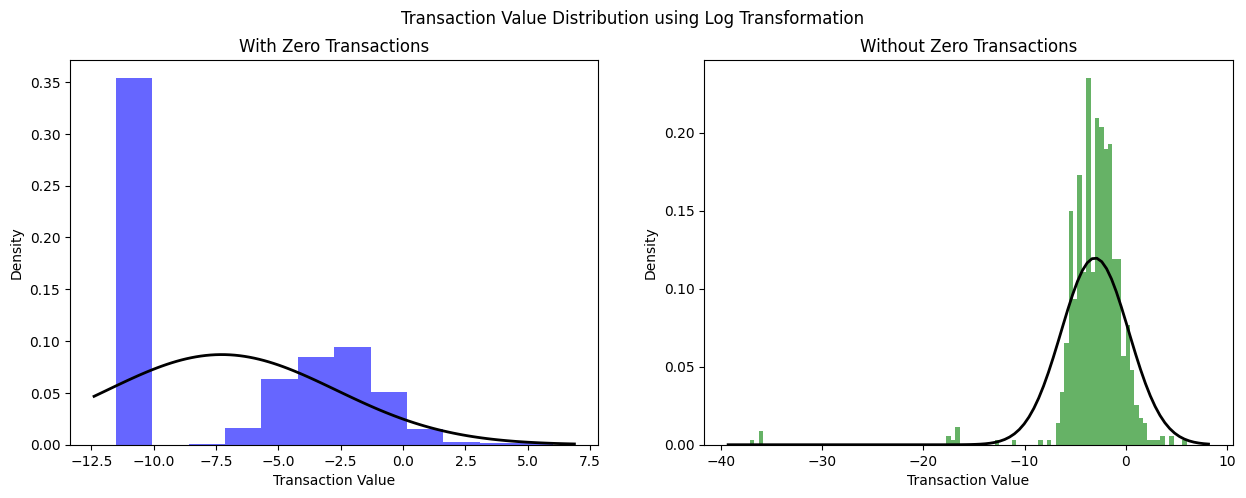

In [28]:
epsilon = 1e-5
tnx_with_epsilon_as_zero = transactionsDf_with_zero_txn['Value'] + epsilon
bin_size_with_zero_txn = calcBinSize(np.log(tnx_with_epsilon_as_zero))
bin_size_without_zero_txn = calcBinSize(np.log(transactionsDf_without_zero_txn['Value']))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution using Log Transformation')

ax[0].hist(np.log(tnx_with_epsilon_as_zero), bins=bin_size_with_zero_txn, color='blue', density=True, alpha=0.6)
ax[1].hist(np.log(transactionsDf_without_zero_txn['Value']), bins=bin_size_without_zero_txn, color='green', density=True, alpha=0.6)

mu1, std1 = norm.fit(np.log(tnx_with_epsilon_as_zero))
mu2, std2 = norm.fit(np.log(transactionsDf_without_zero_txn['Value']))

xmin1, xmax1 = ax[0].get_xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, std1)
ax[0].plot(x1, p1, 'k', linewidth=2)

xmin2, xmax2 = ax[1].get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
ax[1].plot(x2, p2, 'k', linewidth=2)

ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Value')
ax[0].set_ylabel('Density')

ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Value')
ax[1].set_ylabel('Density')

plt.show()

### Box Plot
Boxplots provide a visual summary of the central tendency and spread of transaction fees in each dataset. The log transformation aids in handling skewed distributions and accentuates features such as quartiles and potential outliers.

The red median lines and differently colored whiskers contribute to a clearer representation of the data distribution in each subplot.

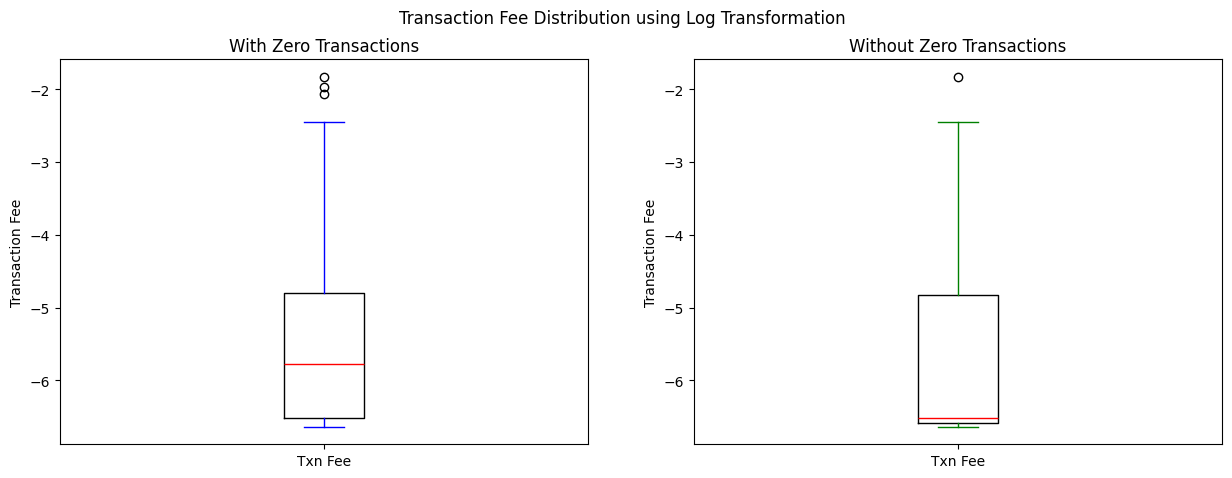

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution using Log Transformation')

boxplot1 = ax[0].boxplot(np.log(transactionsDf_with_zero_txn['Txn Fee']))
ax[0].set_title('With Zero Transactions')
ax[0].set_ylabel('Transaction Fee')
ax[0].set_xticklabels(['Txn Fee'])

boxplot2 = ax[1].boxplot(np.log(transactionsDf_without_zero_txn['Txn Fee']))
ax[1].set_title('Without Zero Transactions')
ax[1].set_ylabel('Transaction Fee')
ax[1].set_xticklabels(['Txn Fee'])

colors = ['blue', 'green']
for box, color in zip([boxplot1, boxplot2], colors):
    for whisker in box['whiskers']:
        whisker.set(color=color, linestyle='-')
    for cap in box['caps']:
        cap.set(color=color)
    for median in box['medians']:
        median.set(color='red')

plt.show()

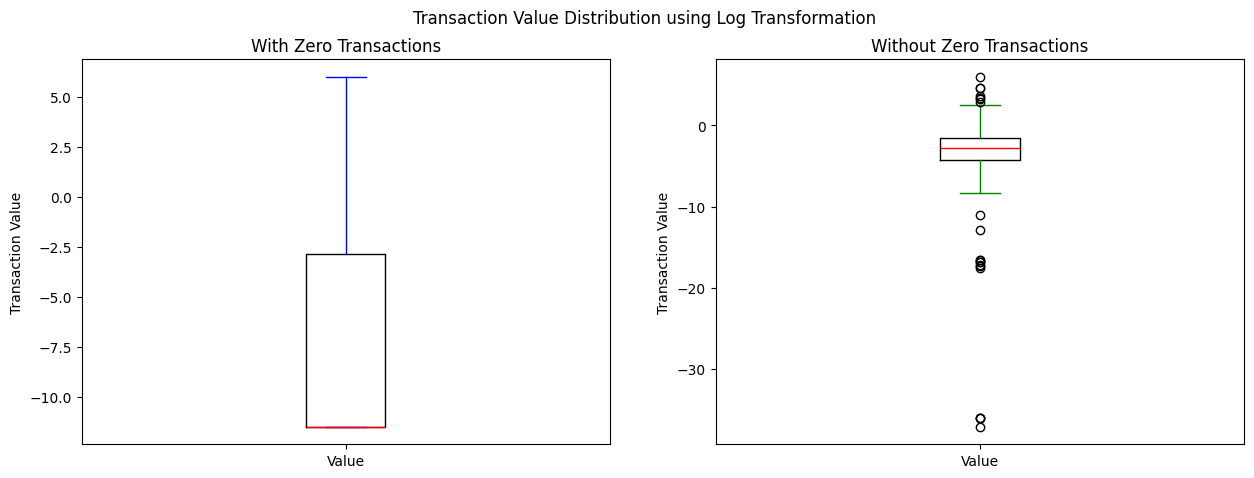

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution using Log Transformation')

boxplot1 = ax[0].boxplot(np.log(tnx_with_epsilon_as_zero))
ax[0].set_title('With Zero Transactions')
ax[0].set_ylabel('Transaction Value')
ax[0].set_xticklabels(['Value'])

boxplot2 = ax[1].boxplot(np.log(transactionsDf_without_zero_txn['Value']))
ax[1].set_title('Without Zero Transactions')
ax[1].set_ylabel('Transaction Value')
ax[1].set_xticklabels(['Value'])

colors = ['blue', 'green']
for box, color in zip([boxplot1, boxplot2], colors):
    for whisker in box['whiskers']:
        whisker.set(color=color, linestyle='-')
    for cap in box['caps']:
        cap.set(color=color)
    for median in box['medians']:
        median.set(color='red')

plt.show()

### Violin Plot
The violin plot provides a visual representation of the probability density of log-transformed transaction fees in each dataset. The inclusion of medians enhances the understanding of central tendencies, while the distinct colors aid in distinguishing between datasets.

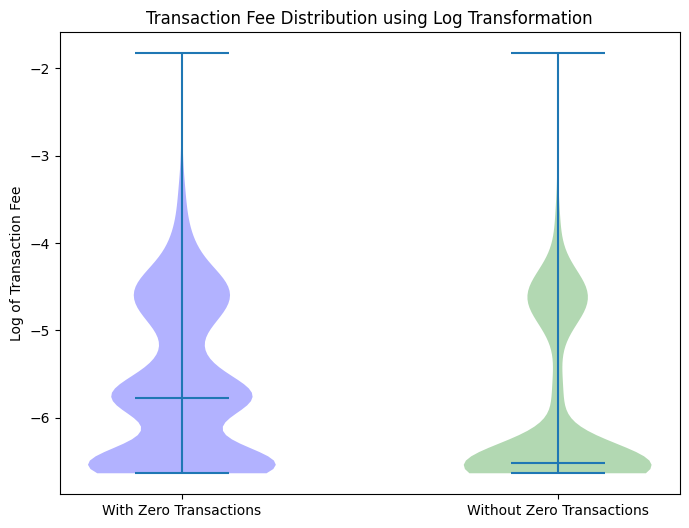

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Fee Distribution using Log Transformation')

violin_parts = ax.violinplot([np.log(transactionsDf_with_zero_txn['Txn Fee']), np.log(transactionsDf_without_zero_txn['Txn Fee'])], showmedians=True)

colors = ['blue', 'green']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Fee')
ax.set_xticks([1, 2])
ax.set_xticklabels(['With Zero Transactions', 'Without Zero Transactions'])

plt.show()


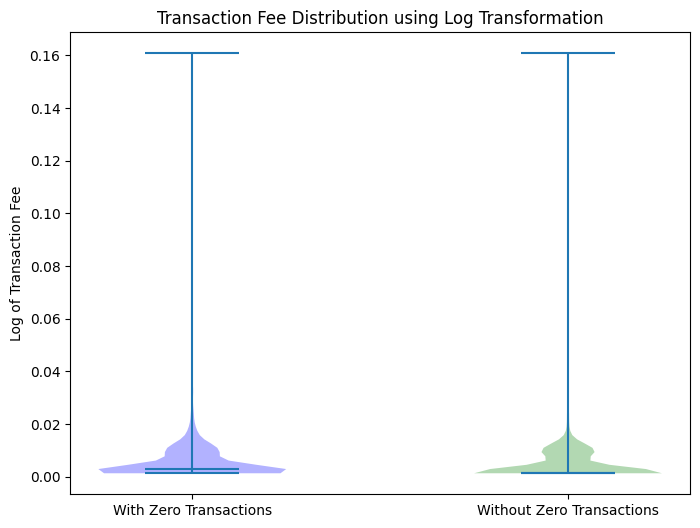

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Fee Distribution using Log Transformation')

violin_parts = ax.violinplot([transactionsDf_with_zero_txn['Txn Fee'], transactionsDf_without_zero_txn['Txn Fee']], showmedians=True)

colors = ['blue', 'green']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Fee')
ax.set_xticks([1, 2])
ax.set_xticklabels(['With Zero Transactions', 'Without Zero Transactions'])

plt.show()

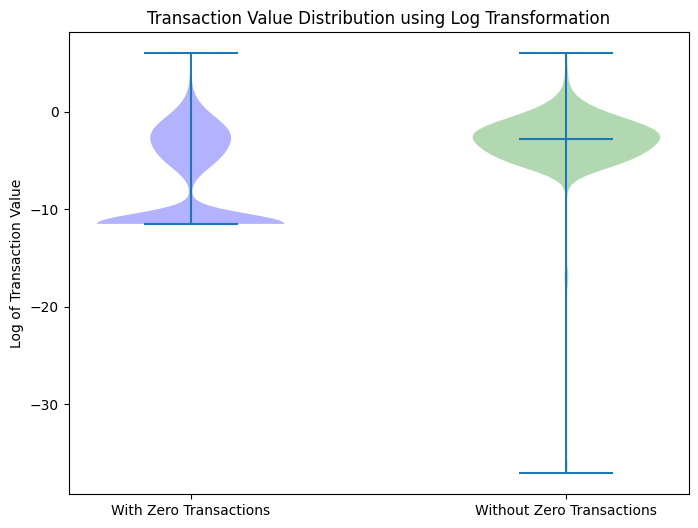

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Value Distribution using Log Transformation')

violin_parts = ax.violinplot([np.log(tnx_with_epsilon_as_zero), np.log(transactionsDf_without_zero_txn['Value'])], showmedians=True)

colors = ['blue', 'green']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Value')
ax.set_xticks([1, 2])
ax.set_xticklabels(['With Zero Transactions', 'Without Zero Transactions'])

plt.show()

[Text(1, 0, 'With Zero Transactions'), Text(2, 0, 'Without Zero Transactions')]

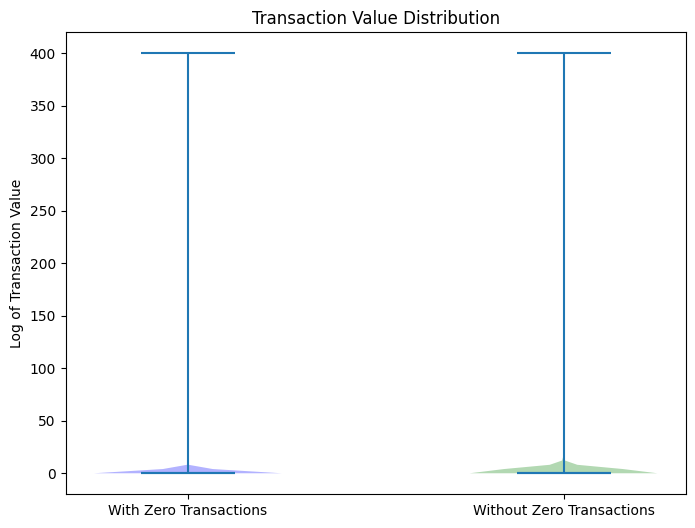

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Value Distribution')

violin_parts = ax.violinplot([transactionsDf_with_zero_txn['Value'], transactionsDf_without_zero_txn['Value']], showmedians=True)

colors = ['blue', 'green']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Value')
ax.set_xticks([1, 2])
ax.set_xticklabels(['With Zero Transactions', 'Without Zero Transactions'])

## Sampling Data

The function uses a formula to determine the appropriate sample size based on the specified margin of error and confidence level. The function returns the calculated sample size as a proportion of the population size. If the calculated sample size is less than 20% of the population size, it returns 0.2 (20%) instead.  
`max(n/df.shape[0], 0.2)`: This line ensures that the calculated sample size is at least 20% of the population size. It's a way to prevent the sample size from being too small relative to the population size.

In [35]:
def calcSampleProportion(df):
    z_score = 1.96
    margin_error = 0.05
    std_dev = df['Txn Fee'].std()
    numerator = ((z_score ** 2) * (std_dev * (1-std_dev))) / (margin_error ** 2)
    denominator = 1 + (((z_score ** 2) * (std_dev * (1-std_dev))) / ((margin_error ** 2) * (df.shape[0])))
    n = int(numerator / denominator)
    return max(n/df.shape[0], 0.2)

At first we will have a brief overview of the data and statistical summary of the data.

In [36]:
transactionsDf_with_zero_txn[['Value', 'Txn Fee']].describe()

,Value,Txn Fee
count,1668.000000,1668.000000
mean,0.576101,0.005793
std,10.496836,0.008577
min,0.000000,0.001310
25%,0.000000,0.001483
50%,0.000000,0.003091
75%,0.057130,0.008233
max,400.004643,0.160783


### Simple Random Sampling (SRS)

We use the sample method to select a simple random sample from the DataFrame. We specify the sample size using the calculated sample size. We set the random_state parameter to 42 to ensure reproducibility. The statistical summary of the sample is also displayed.

In [37]:
sample_size = round(calcSampleProportion(transactionsDf_with_zero_txn) * transactionsDf_with_zero_txn.shape[0])
simple_random_sampled = transactionsDf_with_zero_txn.sample(n=sample_size, random_state=42)
display(simple_random_sampled[['Value', 'Txn Fee']].describe())

,Value,Txn Fee
count,334.000000,334.000000
mean,0.202243,0.006705
std,0.861954,0.011772
min,0.000000,0.001310
25%,0.000000,0.001509
50%,0.002282,0.003110
75%,0.071500,0.008703
max,12.000000,0.160783


### Stratified Sampling

For  stratified sampling, we use three characteristics to stratify the data: `Block', 'Method', and 'Value'. We calculate the sample size for each stratum using the formula for sample size calculation. We use the sample method to select a stratified random sample from the DataFrame. We specify the sample size for each stratum using the calculated sample size. The statistical summary of the sample is also displayed.

In [39]:
stratified_sampled_block = pd.DataFrame()

for method, group in transactionsDf_with_zero_txn.groupby('Block'):
    num_samples = round(len(group) * calcSampleProportion(transactionsDf_with_zero_txn))
    sampled_group = group.sample(n=num_samples, random_state=42)
    stratified_sampled_block = pd.concat([stratified_sampled_block, sampled_group])

stratified_sampled_block[['Value', 'Txn Fee']].describe()

,Value,Txn Fee
count,336.000000,336.000000
mean,0.163004,0.005634
std,1.016256,0.006340
min,0.000000,0.001310
25%,0.000000,0.001483
50%,0.000000,0.003075
75%,0.050278,0.008083
max,17.646021,0.060091


According to numerous values for 'Method', we decided to use top 9 most frequent values for 'Method' and group the rest of the values into 'Other' category. In order not to lose the information of 'Method' column, we added a new column named 'New Method' to the DataFrame.

In [40]:
transactionsDf_with_zero_txn['New Method'] = transactionsDf_with_zero_txn['Method']
transactionsDf_with_zero_txn

,Txn Hash,Method,Block,Value,Txn Fee,New Method
0,0x46d8f310d4dc9d8adfade1901538db7d6e8252b19633...,Transfer,19399902,0.092026,0.001379,Transfer
1,0x13a652a17060859a7f9ba807dd9bd0973f94f0a5a63b...,Sell To Uniswap,19399902,0.000000,0.007101,Sell To Uniswap
2,0x248c1b05c4e64921d19d0228732e0327a6b11e7dcefe...,Transfer,19399902,0.000000,0.003823,Transfer
3,0x168dcebb2e5901d96bdf8351462a61f97d4fc0c891c1...,Transfer,19399902,3.078826,0.001352,Transfer
4,0x3a9df82cd6692b6797565f017021a9e478af74d887a5...,Transfer,19399902,0.028741,0.001352,Transfer
...,...,...,...,...,...,...
2290,0x75bb7d7bef34fcd63169dea3677b5b3c2ecf432b6d2f...,Swap Exact Token...,19399893,0.000000,0.010116,Swap Exact Token...
2291,0x9badd61c1eb9df5bda1440582cd016a057eb9eb1b690...,Swap Exact Token...,19399893,0.000000,0.012506,Swap Exact Token...
2292,0xa965a45bd08eb24b2eee64ecbab69734f56c9ff13e94...,0x6d0de176,19399893,0.350000,0.011188,0x6d0de176
2293,0xed93dd640d76b67d86c35b35c595bfa5f41b3dfb4f0e...,0x0162e2d0,19399893,0.500000,0.012380,0x0162e2d0


The DataFrame is grouped by the 'New Method' column using groupby(). For each group (method), the number of samples to be taken is calculated based on the proportion returned by calcSampleProportion(). The sample method is used to select a stratified random sample from the DataFrame. The statistical summary of the sample is also displayed.

In [41]:
stratified_sampled = pd.DataFrame()

top_9_methods = transactionsDf_with_zero_txn['New Method'].value_counts().nlargest(9).index
transactionsDf_with_zero_txn.loc[~transactionsDf_with_zero_txn['New Method'].isin(top_9_methods), 'New Method'] = 'Other'

for method, group in transactionsDf_with_zero_txn.groupby('New Method'):
    num_samples = round(len(group) * calcSampleProportion(transactionsDf_with_zero_txn))
    sampled_group = group.sample(n=num_samples, random_state=42)
    stratified_sampled = pd.concat([stratified_sampled, sampled_group])

stratified_sampled[['Value', 'Txn Fee']].describe()

,Value,Txn Fee
count,3.340000e+02,334.000000
mean,4.533740e-01,0.006258
std,5.582536e+00,0.011454
min,0.000000e+00,0.001310
25%,0.000000e+00,0.001443
50%,5.600000e-08,0.003012
75%,4.995349e-02,0.008379
max,1.016807e+02,0.160783


The DataFrame is grouped by the 'Value' column using 'groupby()'. For each group (value range), the number of samples to be taken is calculated based on the proportion of that range in the population. The sample method is used to select a stratified random sample from the DataFrame. The statistical summary of the sample is also displayed.

In [42]:
stratified_sampled_value = pd.DataFrame()
stratified_sampled_value = transactionsDf_with_zero_txn.groupby('Value', group_keys=False).apply(lambda x: x.sample(frac=calcSampleProportion(transactionsDf_with_zero_txn), random_state=42))

stratified_sampled_value[['Value', 'Txn Fee']].describe()

C:\Users\Amir Ali\AppData\Local\Temp\ipykernel_10624\1709011416.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sampled_value = transactionsDf_with_zero_txn.groupby('Value', group_keys=False).apply(lambda x: x.sample(frac=calcSampleProportion(transactionsDf_with_zero_txn), random_state=42))


,Value,Txn Fee
count,214.000000,214.000000
mean,0.042444,0.006321
std,0.185173,0.005300
min,0.000000,0.001312
25%,0.000000,0.003046
50%,0.000000,0.003802
75%,0.000000,0.008896
max,2.000000,0.035052


The code below visually compares the distribution of transaction fees between the original data, a stratified sample, and a simple random sample using histograms. The logarithm transformation is applied to the transaction fees for better visualization. Using Log transformation is a common practice when dealing with data that has many values that are close to zero. It helps to make the data more interpretable and easier to visualize.

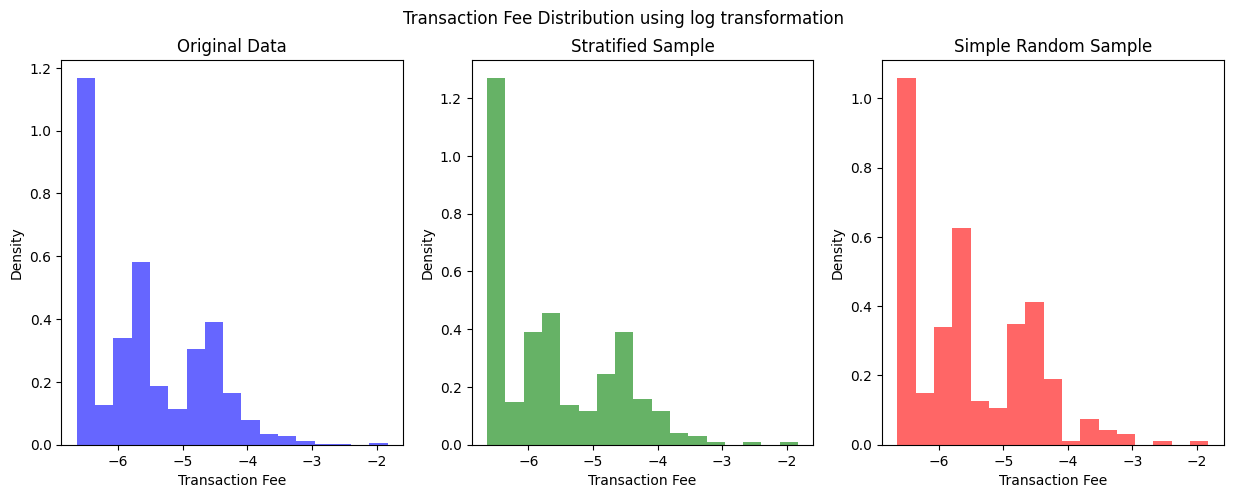

In [43]:
bin_size_original = calcBinSize(np.log(transactionsDf_with_zero_txn['Txn Fee']))
bin_size_stratified = bin_size_original
bin_size_simple = bin_size_original

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution using log transformation')

ax[0].hist(np.log(transactionsDf_with_zero_txn['Txn Fee']), bins=bin_size_original, color='blue', density=True, alpha=0.6)
ax[0].set_title('Original Data')
ax[0].set_xlabel('Transaction Fee')
ax[0].set_ylabel('Density')

ax[1].hist(np.log(stratified_sampled['Txn Fee']), bins=bin_size_stratified, color='green', density=True, alpha=0.6)
ax[1].set_title('Stratified Sample')
ax[1].set_xlabel('Transaction Fee')
ax[1].set_ylabel('Density')

ax[2].hist(np.log(simple_random_sampled['Txn Fee']), bins=bin_size_simple, color='red', density=True, alpha=0.6)
ax[2].set_title('Simple Random Sample')
ax[2].set_xlabel('Transaction Fee')
ax[2].set_ylabel('Density')

plt.show()

As we can see from the above plots, the stratified sample and simple random sample have a similar distribution to the original data. This is because the sample size is large enough to capture the distribution of the original data. The stratified sample has a similar distribution to the original data, but it is more representative of the population because it captures the distribution of the original data for each stratum. The simple random sample also captures the distribution of the original data, but it may not be as representative of the population as the stratified sample because it may not capture the distribution of the original data for each stratum.

As the calculation of Log 0 is undefined, we need to use a small value to replace 0 in the data. We use the epsilon value to replace 0 in the data. The epsilon value is a small positive number that is added to the data to avoid taking the logarithm of 0. 

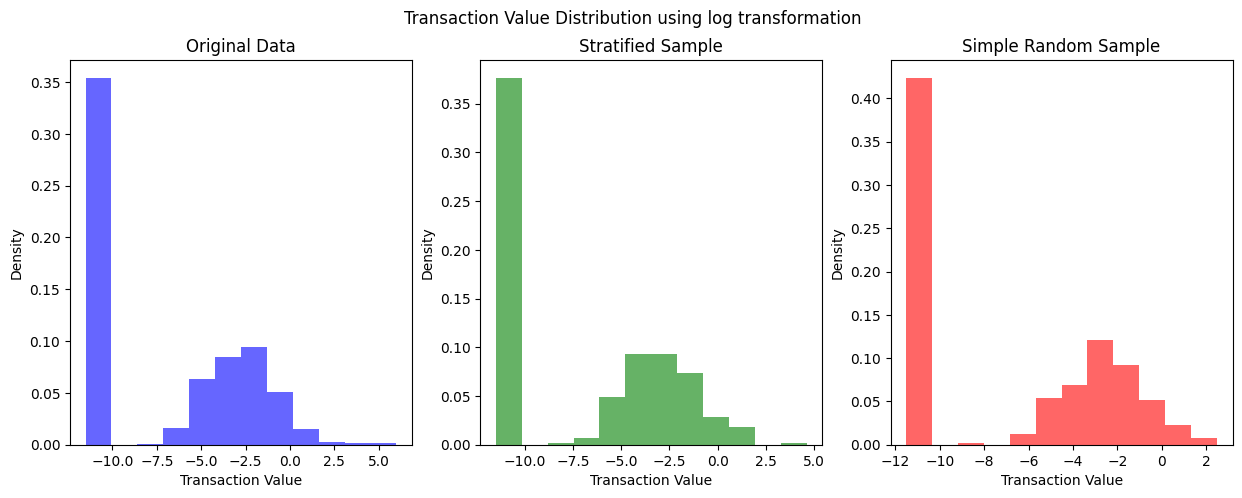

In [44]:
stratified_sampled_plus_epsilon = stratified_sampled['Value'] + epsilon
transactionsDf_with_zero_txn_plus_epsilon = transactionsDf_with_zero_txn['Value'] + epsilon
simple_random_sampled_plus_epsilon = simple_random_sampled['Value'] + epsilon

bin_size_original = calcBinSize(np.log(transactionsDf_with_zero_txn_plus_epsilon))
bin_size_stratified = bin_size_original
bin_size_simple = bin_size_original

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution using log transformation')

ax[0].hist(np.log(transactionsDf_with_zero_txn_plus_epsilon), bins=bin_size_original, color='blue', density=True, alpha=0.6)
ax[0].set_title('Original Data')
ax[0].set_xlabel('Transaction Value')
ax[0].set_ylabel('Density')

ax[1].hist(np.log(stratified_sampled_plus_epsilon), bins=bin_size_stratified, color='green', density=True, alpha=0.6)
ax[1].set_title('Stratified Sample')
ax[1].set_xlabel('Transaction Value')
ax[1].set_ylabel('Density')

ax[2].hist(np.log(simple_random_sampled_plus_epsilon), bins=bin_size_simple, color='red', density=True, alpha=0.6)
ax[2].set_title('Simple Random Sample')
ax[2].set_xlabel('Transaction Value')
ax[2].set_ylabel('Density')

plt.show()

As we can see from the above plots, the result for the 'Value' column is similar to the result for the 'Tnx Fee' column. 

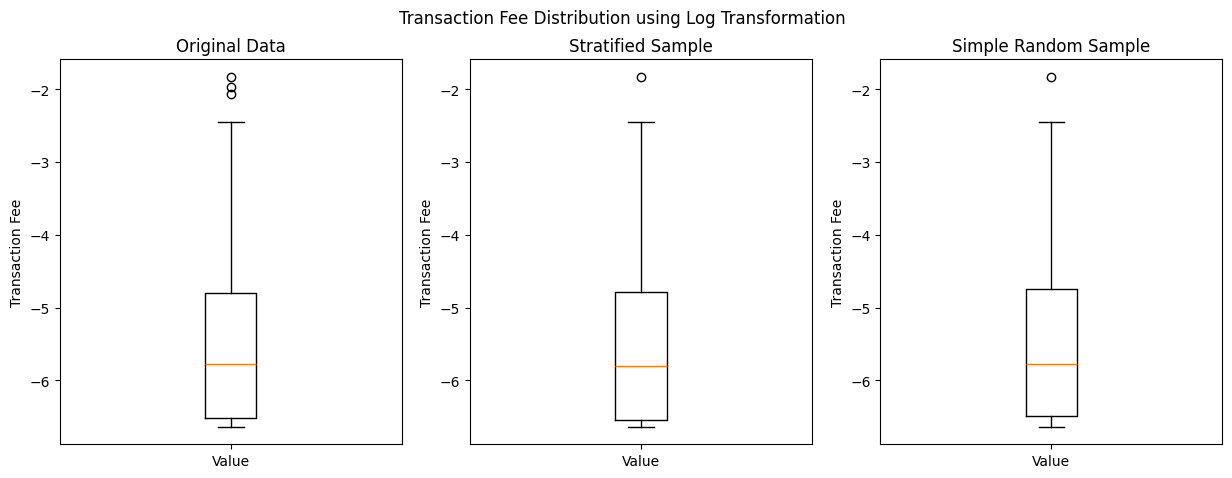

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution using Log Transformation')

boxplot1 = ax[0].boxplot(np.log(transactionsDf_with_zero_txn['Txn Fee']))
ax[0].set_title('Original Data')
ax[0].set_ylabel('Transaction Fee')
ax[0].set_xticklabels(['Value'])

boxplot2 = ax[1].boxplot(np.log(stratified_sampled['Txn Fee']))
ax[1].set_title('Stratified Sample')
ax[1].set_ylabel('Transaction Fee')
ax[1].set_xticklabels(['Value'])

boxplot3 = ax[2].boxplot(np.log(simple_random_sampled['Txn Fee']))
ax[2].set_title('Simple Random Sample')
ax[2].set_ylabel('Transaction Fee')
ax[2].set_xticklabels(['Value'])

plt.show()

By interpreting these elements of the box plot, we can gain insights into the central tendency, spread, and distribution of the dataset, as well as identify potential outliers or anomalies. As we expected, the median value of the stratified and simple random samples are similar to the median value of the original data. 

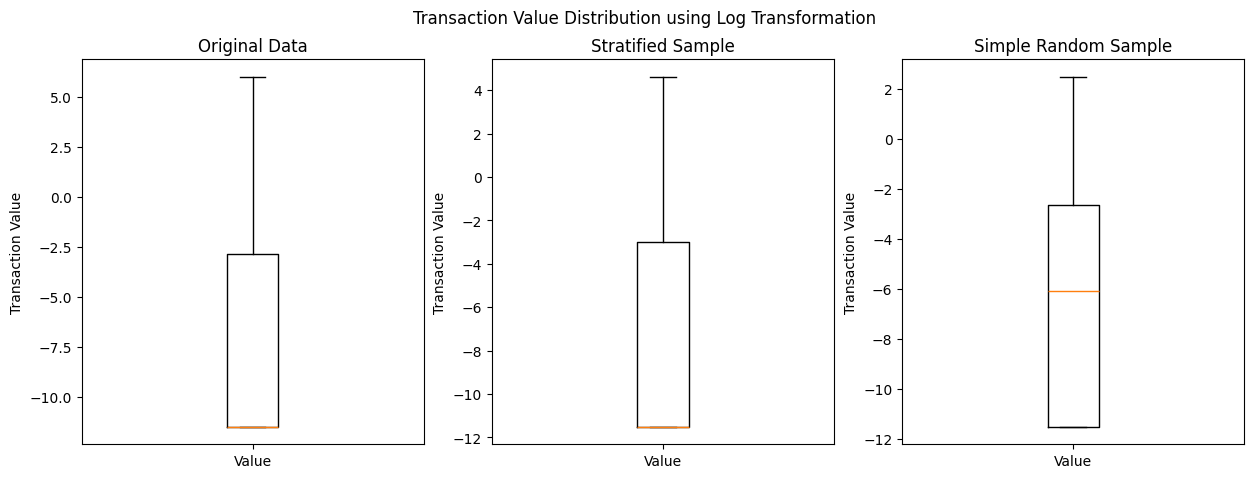

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution using Log Transformation')

boxplot1 = ax[0].boxplot(np.log(transactionsDf_with_zero_txn_plus_epsilon))
ax[0].set_title('Original Data')
ax[0].set_ylabel('Transaction Value')
ax[0].set_xticklabels(['Value'])

boxplot2 = ax[1].boxplot(np.log(stratified_sampled_plus_epsilon))
ax[1].set_title('Stratified Sample')
ax[1].set_ylabel('Transaction Value')
ax[1].set_xticklabels(['Value'])

boxplot3 = ax[2].boxplot(np.log(simple_random_sampled_plus_epsilon))
ax[2].set_title('Simple Random Sample')
ax[2].set_ylabel('Transaction Value')
ax[2].set_xticklabels(['Value'])

plt.show()

As we can see from the above plots, the result for the 'Value' column for Stratified is more similar to the original data than the result for Simple Random Sample.

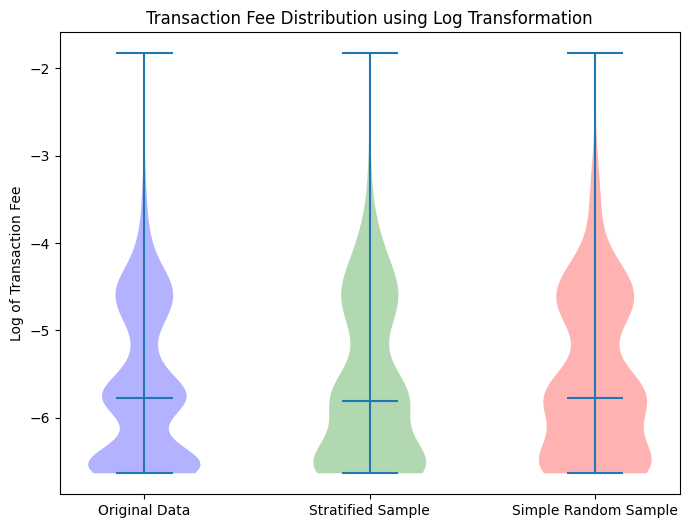

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Fee Distribution using Log Transformation')

violin_parts = ax.violinplot([np.log(transactionsDf_with_zero_txn['Txn Fee']), np.log(stratified_sampled['Txn Fee']), np.log(simple_random_sampled['Txn Fee'])], showmedians=True)
colors = ['blue', 'green', 'red']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Fee')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Original Data', 'Stratified Sample', 'Simple Random Sample'])

plt.show()

Violin plots provide a richer visualization of the distribution of the data compared to box plots, as they incorporate information about both the central tendency and spread of the data, as well as the shape of the distribution. As we can see from the above plots, the result for the 'Txn Fee' column for both Stratified and Simple Random samples are similar to original data. 

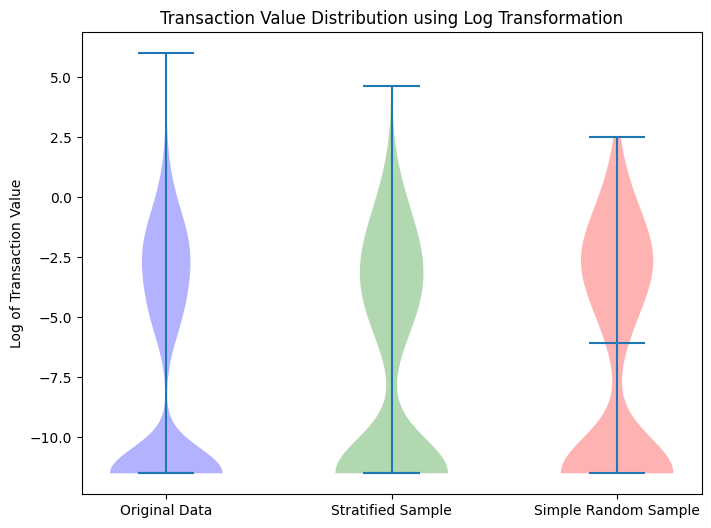

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Value Distribution using Log Transformation')

violin_parts = ax.violinplot([np.log(transactionsDf_with_zero_txn_plus_epsilon), np.log(stratified_sampled_plus_epsilon), np.log(simple_random_sampled_plus_epsilon)], showmedians=True)
colors = ['blue', 'green', 'red']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Value')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Original Data', 'Stratified Sample', 'Simple Random Sample'])

plt.show()

As we can see from the above plots, the result for the 'Value' column for both samples (especially for Stratified) are similar to the original data.

Statistical summary (including mean and std) of the original data, stratified sample (with three characteristics as strata), and simple random sample are displayed. The summary statistics of the stratified sample are more similar to the original data than the summary statistics of the simple random sample. This is because the stratified sample captures the distribution of the original data for each stratum, while the simple random sample may not capture the distribution of the original data for each stratum.

In [49]:
original_df = transactionsDf_with_zero_txn[['Value', 'Txn Fee']].describe().T[['mean', 'std']]
stratified_df = stratified_sampled[['Value', 'Txn Fee']].describe().T[['mean', 'std']]
simple_random_df = simple_random_sampled[['Value', 'Txn Fee']].describe().T[['mean', 'std']]
stratified_df_value = stratified_sampled_value[['Value', 'Txn Fee']].describe().T[['mean', 'std']]
stratified_df_block = stratified_sampled_block[['Value', 'Txn Fee']].describe().T[['mean', 'std']]

combined_stats = pd.concat([original_df, stratified_df, stratified_df_value, stratified_df_block,  simple_random_df], axis=0, keys=['Original', 'Stratified Method', 'Stratified Value', 'Stratified Block', 'Simple Random Sample'])

print(combined_stats)

                                  mean        std
Original             Value    0.576101  10.496836
                     Txn Fee  0.005793   0.008577
Stratified Method    Value    0.453374   5.582536
                     Txn Fee  0.006258   0.011454
Stratified Value     Value    0.042444   0.185173
                     Txn Fee  0.006321   0.005300
Stratified Block     Value    0.163004   1.016256
                     Txn Fee  0.005634   0.006340
Simple Random Sample Value    0.202243   0.861954
                     Txn Fee  0.006705   0.011772


## Questions

1. `What are some potential limitations when using web scraping for data collection? Specifically, what problems did you face while fetching data from Etherscan? What problems can these limitations cause in your analysis?`

Some potential limitations when using web scraping for data collection include:
- Dynamic Content and AJAX:
Websites that heavily rely on JavaScript and AJAX to load content dynamically may be challenging to scrape. Traditional scraping tools may struggle to capture data loaded after the initial page load.
- Incomplete or Inaccurate Data:
Some websites may use client-side rendering, which means the initial HTML document may lack complete data. APIs or headless browsers may be needed to access the fully rendered content. Data may also be inaccurate due to inconsistencies or errors on the website.
- Dependency on Website Stability:
If a website undergoes major changes or goes offline, it can disrupt the scraping process. Relying on a single source for critical data poses a risk to the continuity of your data collection efforts.  
One of the problems that we face was that the website could not load the traffic data for the last 10 blocks. This is because the website has a limit on the number of requests that can be made in a certain period of time. To solve this problem, we made a delay between each request to the website by adding a delay of 0.2 seconds after clicking on the "Next" button. This allowed us to fetch the data without exceeding the website's request limit.  
One of the other problems that we face was that the website had loaded new data when we clicked on the "Next" button. To solve this problem we removed the repetitive data based on the transaction hash and also removed any transaction that has a block number larger than the latest block number that we had at first.

2.  `What can make your analysis untrustworthy? What are your solutions?`

**Biased Data:**

Issue: If the data used for analysis is biased or not representative of the population, the results may be skewed.

Solution: Ensure that the data collected is diverse and representative. Consider using sampling techniques that reduce bias, and be transparent about any limitations in the data.

**Incomplete Data:**

Issue: Missing or incomplete data can lead to inaccurate conclusions or biased results.

Solution: Implement robust data collection methods, handle missing data appropriately (e.g., imputation), and clearly communicate any limitations in the dataset.

3.  `How did the visualization help you in understanding the data? What could you interpret from the plots?` 

Pattern Recognition:\
Visualizations help in identifying patterns, trends, and relationships within the data that may not be apparent in raw tabular data. Line charts, scatter plots, and bar graphs, for example, can reveal patterns over time or associations between variables.

Distribution Understanding:\
Histograms and kernel density plots help in understanding the distribution of data. This is crucial for assessing the central tendency, spread, and shape of the data, which informs decisions about which statistical methods to use.

Correlation Assessment:\
Scatter plots or heatmaps can visually represent correlations between variables. Understanding the strength and direction of these correlations is essential for making informed decisions in data analysis.

Time Series Analysis:\
Line charts or stacked area charts are valuable for understanding trends and patterns over time. Seasonal variations, long-term trends, and cyclic patterns can be easily spotted.

Data Distribution and Skewness:\
Visualizations like box plots and violin plots provide insights into the skewness and kurtosis of the data distribution. This is important for selecting appropriate statistical methods and understanding the nature of the data.

Simplifying:\
It can help us to Simplify complex data by presenting it in a graphical form. it increases accessibility by making data more understandable for different audiences.

We could also interpret other aspects of the data, such as The outliers or anomalies that deviate from the norm and the comparison or contrast between different groups or categories

4.  `How do the two sampling methods differ in their output? Compare these and explain which one is a better fit to the population.` 

Simple random sampling randomly selects individuals from the entire population without any other consideration. This means that every member of the population has an equal chance of being included in the sample. The output of this method is a sample that is representative of the population as a whole.  
Stratified sampling first splits the population into smaller groups, based on shared characteristics (in this case: Method and Value of the data). Then, it randomly selects some members from each group to form the sample. This means that every group of the population is represented in the sample proportionally. The output of this method is a sample that is representative of the population's diversity.  
We use simple random sampling when the population is homogeneous, or when there is little or no information about the population's characteristics. This method is easy to implement and unbiased, but it may not capture the variability of the population.  
Stratified sampling is used when the population is heterogeneous, or when there is information about the population's characteristics. This method can reduce sampling error and increase precision, but it requires more effort to implement.  
In this project, we had some prior knowledge about the data, such as the method and some other attributes. Therefore, as we anticipated, stratified sampling yielded a better outcome.